# TCC

- Problema: localização de minérios
- Solução: aplicação de aprendizado de máquina com uso de dados de espectrometria e gravimetria para classificar locais com alta probabilidade de conter minérios
  - Minério de estudo: cobre

- Alteração em relação a v1: desconsideração de variáveis de geolocalização pelo modelo

---
- Processamento:
  - Problemas: 
    - conversão de coordenadas para latitude/longitude e uso de 2 casas decimais para evitar perda de dados durante mesclagem de dados

  - Aprendizado de máquina:
    - desbalanceamento entre classes

---

Ref Github: https://github.com/lszam/mineralexp

In [1]:
import os
import sys
import time
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import pyproj
from warnings import filterwarnings
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    auc,
    f1_score,
    classification_report,
    precision_recall_curve,
    average_precision_score,
)
import shap
import folium
from branca.element import Figure

filterwarnings("ignore")

sys.tracebacklimit = 0

/home/renan/study/tcc_univesp/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dir_projeto = Path(os.getcwd()).parent.absolute().parent.absolute()
data_dir = Path(dir_projeto, "Output", "tcc", "v1")
shp_dir = Path(data_dir, "shp")

In [3]:
# arredondamento de casas decimais para conversão de coordenadas geográficas
arredondamento = 2

## funções

### coordenadas geográficas

In [4]:
def utm_to_latlon(
    df: pd.DataFrame,
    x_col: str = "X",
    y_col: str = "Y",
    utm_zone: int = 22,
    southern_hemisphere: bool = True,
    arredondamento: int = 3,
) -> pd.DataFrame:
    """
    Convert UTM coordinates to latitude/longitude (WGS84)

    Parameters:
    - df: DataFrame containing coordinates
    - x_col: Column name for easting (UTM X)
    - y_col: Column name for northing (UTM Y)
    - utm_zone: UTM zone number (Brazil is mostly zones 22-25)
    - southern_hemisphere: True for southern hemisphere (Brazil)

    Returns:
    DataFrame with new 'longitude' and 'latitude' columns
    """
    # Create UTM coordinate system
    utm = pyproj.Proj(proj="utm", zone=utm_zone, south=southern_hemisphere)

    # Create WGS84 coordinate system
    wgs84 = pyproj.Proj(proj="latlong", datum="WGS84")

    # Convert coordinates
    lon, lat = pyproj.transform(utm, wgs84, df[x_col].values, df[y_col].values)

    # Add to DataFrame
    df = df.copy()
    df["longitude"] = lon
    df["latitude"] = lat

    df["longitude"] = df["longitude"].round(arredondamento)
    df["latitude"] = df["latitude"].round(arredondamento)

    return df


def convert_shapefile_to_latlon(shapefile_path: Path) -> gpd.GeoDataFrame:
    """
    Read a shapefile and convert coordinates to latitude/longitude (WGS84)

    Parameters:
    - shapefile_path: path for the shapefile

    Returns:
    GeoDataFrame
    """
    gdf = gpd.read_file(shapefile_path)
    if gdf.crs is None:
        # Assuming it's in the same UTM as your other data
        gdf.crs = "+proj=utm +zone=22 +south +datum=WGS84 +units=m +no_defs"
    gdf = gdf.to_crs(epsg=4326)  # Convert to WGS84 (lat/lon)
    if not os.path.basename(shapefile_path) == "estruturas_ln.shp":
        gdf["longitude"] = gdf.geometry.x
        gdf["latitude"] = gdf.geometry.y
    return gdf

### processamento

In [5]:
def clusterizar_coordenadas_geograficas(df: pd.DataFrame, n_clusters: np.int16 = 8) -> pd.DataFrame:
    """Aplica clusterização nas coordenadas geográficas para modelo de aprendizado de máquina,
    como feature engineering

    Args:
        df (pd.DataFrame): dataframe com dados de coordenadas geográficas
        n_clusters (np.int16, optional): número de clusters. Defaults to 8.

    Returns:
        pd.DataFrame: dataframe com clusters de coordenadas
    """
    coords = df[["longitude", "latitude"]].values
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(coords)
    df["geo_cluster"] = kmeans.labels_
    dict_map_idx_lon = dict(zip(df.index, df["longitude"]))
    dict_map_idx_lat = dict(zip(df.index, df["latitude"]))
    df = df.drop(["longitude", "latitude"], axis=1)
    return df, dict_map_idx_lon, dict_map_idx_lat


### aprendizado de máquina

In [6]:
def split_data(X, y, test_size: np.float16 = 0.3) -> tuple:
    """Divide dados de treino e teste

    Args:
        df (pd.DataFrame): dataframe com dados
        test_size (np.float16, optional): tamanho dos dados de teste. Defaults to 0.3.

    Returns:
        tuple: _description_
    """
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=test_size,
        random_state=420,
        stratify=y,  # dados desbalanceados
    )

    print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
    print(f"Class balance - Train: {y_train.mean():.2%}, Test: {y_test.mean():.2%}")

    return X_train, X_test, y_train, y_test

In [7]:
def pipeline_ml(
    models: dict,
    cv: StratifiedKFold,
    X_train: np.array,
    X_test: np.array,
    y_train: np.array,
    y_test: np.array,
) -> dict:
    """Pipeline para modelos de aprendizado de máquina, realizando treinamento com validação cruzada e avaliação

    Args:
        models (dict): dicionário com modelos
        cv (StratifiedKFold): validação cruzada
        X_train (np.array): array de dados independentes de treino
        X_test (np.array): array de dados independentes de teste
        y_train (np.array): array de dados dependentes de treino
        y_test (np.array): array de dados dependentes de teste
    """
    results = {}
    for name, model in models.items():
        start_train = time.perf_counter()

        # Create pipeline (scale for logistic regression)
        if name == "Logistic Regression":
            pipe = Pipeline([("scaler", StandardScaler()), ("model", model)])
        else:
            pipe = model

        # Cross-validation
        cv_scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring="roc_auc", n_jobs=-1)

        # Full training
        pipe.fit(X_train, y_train)

        print("\n")
        print(f"Tempo total de treino {name}: {round((time.perf_counter() - start_train) / 60, 2)} min")

        # Store results
        results[name] = {"model": pipe, "cv_mean_auc": cv_scores.mean(), "cv_std_auc": cv_scores.std()}

        print(f"{name} - CV AUC: {cv_scores.mean():.3f} (±{cv_scores.std():.3f})")

        # Evaluate on test set
        if hasattr(pipe, "predict_proba"):
            evaluate_model(pipe, X_test, y_test)

    return results


def evaluate_model(model, X_test: np.array, y_test: np.array) -> None:
    """Função para avaliar o modelo

    Args:
        model (_type_): _description_
        X_test (np.array): array de dados independentes de teste
        y_test (np.array): array de dados dependentes de teste
    """
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    print(f"ROC-AUC: {roc_auc_score(y_test, y_proba):.3f}")
    print(f"F1 Score: {f1_score(y_test, y_pred):.3f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]
    print(f"\nOptimal Decision Threshold: {optimal_threshold:.3f}")
    print("\n")


def evaluate_model_custom(model, X_test: np.array, y_test: np.array, threshold: float) -> None:
    """Função para avaliar o modelo

    Args:
        model (_type_): _description_
        X_test (np.array): array de dados independentes de teste
        y_test (np.array): array de dados dependentes de teste
    """
    y_proba = model.predict_proba(X_test)[:, 1]
    y_pred_custom = (y_proba >= threshold).astype(int)

    print(f"ROC-AUC: {roc_auc_score(y_test, y_proba):.3f}")
    print(f"F1 Score: {f1_score(y_test, y_pred_custom):.3f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_custom))

    precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]
    print(f"\nOptimal Decision Threshold: {optimal_threshold:.3f}")
    print("\n")

In [8]:
def pipeline_ml_undersampling(pipelines, cv, X_train, X_test, y_train, y_test) -> dict:
    results = {}
    # Training and evaluation
    for name, pipeline in pipelines.items():
        print(f"\n=== Training {name} ===")

        start_train = time.perf_counter()

        # Cross-validation
        cv_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring="roc_auc", n_jobs=-1)

        # Full training
        pipeline.fit(X_train, y_train)

        print(f"Tempo total de treino {name}: {round((time.perf_counter() - start_train) / 60, 2)} min")

        # Store results
        results[name] = {
            "model": pipeline,
            "cv_mean_auc": cv_scores.mean(),
            "cv_std_auc": cv_scores.std(),
        }

        # Test set evaluation
        if hasattr(pipeline, "predict_proba"):
            y_proba = pipeline.predict_proba(X_test)[:, 1]
            y_pred = pipeline.predict(X_test)

            # Calculate metrics
            roc_auc = roc_auc_score(y_test, y_proba)
            f1 = f1_score(y_test, y_pred)
            avg_precision = average_precision_score(y_test, y_proba)

            print(f"Test ROC-AUC: {roc_auc:.3f}")
            print(f"Test F1 Score: {f1:.3f}")
            print(f"Test Average Precision: {avg_precision:.3f}")
            print("\nClassification Report:")
            print(classification_report(y_test, y_pred))

            # Find optimal threshold
            precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
            f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
            optimal_idx = np.argmax(f1_scores)
            optimal_threshold = thresholds[optimal_idx]
            print(f"Optimal Decision Threshold: {optimal_threshold:.3f}")

            # Store additional metrics
            results[name].update({
                "test_roc_auc": roc_auc,
                "test_f1": f1,
                "test_avg_precision": avg_precision,
                "optimal_threshold": optimal_threshold,
            })

    # Compare model performance
    print("\n=== Model Comparison ===")
    for name, res in results.items():
        print(f"\n{name}:")
        print(f"CV AUC: {res['cv_mean_auc']:.3f} (±{res['cv_std_auc']:.3f})")
        print(f"Test ROC-AUC: {res['test_roc_auc']:.3f}")
        print(f"Test F1: {res['test_f1']:.3f}")
        print(f"Optimal Threshold: {res['optimal_threshold']:.3f}")

    return results

In [9]:
def pipeline_ml_oversampling(pipelines, cv, X_train, X_test, y_train, y_test) -> dict:
    results = {}

    min_minority_samples = min([
        np.sum(y_train[test_idx] == 1) for _, test_idx in cv.split(X_train, y_train)
    ])

    k_neighbors = min(5, min_minority_samples - 1) if min_minority_samples > 1 else 1

    # Training and evaluation
    for name, model in pipelines.items():
        print(f"\n=== Training {name} ===")

        start_train = time.perf_counter()

        # Create pipeline with SMOTE
        pipeline = ImbPipeline([
            ("smote", SMOTE(random_state=42, sampling_strategy="auto", k_neighbors=k_neighbors)),
            ("classifier", model),
        ])

        try:
            # Cross-validation
            cv_scores = cross_val_score(
                pipeline, X_train, y_train, cv=cv, scoring="roc_auc", n_jobs=-1, error_score="raise"
            )

            # Full training
            pipeline.fit(X_train, y_train)

            print(f"Training time {name}: {round((time.perf_counter() - start_train) / 60, 2)} min")

            # Store results
            results[name] = {
                "model": pipeline,
                "cv_mean_auc": cv_scores.mean(),
                "cv_std_auc": cv_scores.std(),
            }

            print(f"CV AUC: {cv_scores.mean():.3f} (±{cv_scores.std():.3f})")

            # Test set evaluation
            if hasattr(model, "predict_proba"):
                y_proba = pipeline.predict_proba(X_test)[:, 1]
                y_pred = pipeline.predict(X_test)

                # Calculate metrics
                roc_auc = roc_auc_score(y_test, y_proba)
                f1 = f1_score(y_test, y_pred)
                avg_precision = average_precision_score(y_test, y_proba)

                print(f"Test ROC-AUC: {roc_auc:.3f}")
                print(f"Test F1 Score: {f1:.3f}")
                print(f"Test Average Precision: {avg_precision:.3f}")
                print("\nClassification Report:")
                print(classification_report(y_test, y_pred))

                # Find optimal threshold
                precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
                f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
                optimal_idx = np.argmax(f1_scores)
                optimal_threshold = thresholds[optimal_idx]
                print(f"Optimal Decision Threshold: {optimal_threshold:.3f}")

                # Store additional metrics
                results[name].update({
                    "test_roc_auc": roc_auc,
                    "test_f1": f1,
                    "test_avg_precision": avg_precision,
                    "optimal_threshold": optimal_threshold,
                })

        except Exception as e:
            print(f"Failed to train {name}: {str(e)}")
            results[name] = {"error": str(e)}

    # Compare model performance
    print("\n=== Model Comparison ===")
    for name, res in results.items():
        print(f"\n{name}:")
        if "error" in res:
            print(f"Training failed: {res['error']}")
        else:
            print(f"CV AUC: {res['cv_mean_auc']:.3f} (±{res['cv_std_auc']:.3f})")
            if "test_roc_auc" in res:
                print(f"Test ROC-AUC: {res['test_roc_auc']:.3f}")
                print(f"Test F1: {res['test_f1']:.3f}")
                print(f"Optimal Threshold: {res['optimal_threshold']:.3f}")

    return results

In [10]:
def pipeline_ml_smote_tomek(pipelines, cv, X_train, X_test, y_train, y_test) -> dict:
    results = {}

    # Training and evaluation
    for name, model in pipelines.items():
        print(f"\n=== Training {name} ===")

        start_train = time.perf_counter()

        # Create pipeline with SMOTETomek
        pipeline = ImbPipeline([
            (
                "smote_tomek",
                SMOTETomek(
                    random_state=42,
                    tomek=TomekLinks(sampling_strategy="majority"),
                    smote=SMOTE(k_neighbors=2),  # Reduce from default 5
                ),
            ),
            ("classifier", model),
        ])

        # Cross-validation
        cv_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring="roc_auc", n_jobs=-1)

        # Full training
        pipeline.fit(X_train, y_train)

        print(
            f"Total training time for {name}: {round((time.perf_counter() - start_train) / 60, 2)} min"
        )

        # Store results
        results[name] = {
            "model": pipeline,
            "cv_mean_auc": cv_scores.mean(),
            "cv_std_auc": cv_scores.std(),
        }

        # Test set evaluation
        if hasattr(model, "predict_proba"):  # Check the original model for predict_proba
            y_proba = pipeline.predict_proba(X_test)[:, 1]
            y_pred = pipeline.predict(X_test)

            # Calculate metrics
            roc_auc = roc_auc_score(y_test, y_proba)
            f1 = f1_score(y_test, y_pred)
            avg_precision = average_precision_score(y_test, y_proba)

            print(f"Test ROC-AUC: {roc_auc:.3f}")
            print(f"Test F1 Score: {f1:.3f}")
            print(f"Test Average Precision: {avg_precision:.3f}")
            print("\nClassification Report:")
            print(classification_report(y_test, y_pred))

            # Find optimal threshold
            precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
            f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
            optimal_idx = np.argmax(f1_scores)
            optimal_threshold = thresholds[optimal_idx]
            print(f"Optimal Decision Threshold: {optimal_threshold:.3f}")

            # Store additional metrics
            results[name].update({
                "test_roc_auc": roc_auc,
                "test_f1": f1,
                "test_avg_precision": avg_precision,
                "optimal_threshold": optimal_threshold,
            })

    # Compare model performance
    print("\n=== Model Comparison ===")
    for name, res in results.items():
        print(f"\n{name}:")
        print(f"CV AUC: {res['cv_mean_auc']:.3f} (±{res['cv_std_auc']:.3f})")
        if "test_roc_auc" in res:
            print(f"Test ROC-AUC: {res['test_roc_auc']:.3f}")
            print(f"Test F1: {res['test_f1']:.3f}")
            print(f"Optimal Threshold: {res['optimal_threshold']:.3f}")

    return results

## leitura e processamento

- leitura dos shapefiles com ocorrências de metais/minas

In [11]:
# ouro = gpd.read_file(Path(shp_dir, 'ocorrencias_Au.shp'))
# # cobre = gpd.read_file(Path(shp_dir, 'ocorrencias_Cu.shp'))
# ferro = gpd.read_file(Path(shp_dir, 'ocorrencias_Fe.shp'))
# # manganes = gpd.read_file(Path(shp_dir, 'ocorrencias_Mn.shp'))
# # niquel = gpd.read_file(Path(shp_dir, 'ocorrencias_Ni.shp'))
# # chumbo = gpd.read_file(Path(shp_dir, 'ocorrencias_Pb.shp'))
# # estanho = gpd.read_file(Path(shp_dir, 'ocorrencias_Sn.shp'))
# minas = gpd.read_file(Path(shp_dir, 'minas.shp'))
# estruturas = gpd.read_file(Path(shp_dir, 'estruturas_ln.shp'))

# ! leitura dos arquivos com conversão para latitude/longitude
# ouro = convert_shapefile_to_latlon(Path(shp_dir, "ocorrencias_Au.shp"))
cobre = convert_shapefile_to_latlon(Path(shp_dir, "ocorrencias_Cu.shp"))
# ferro = convert_shapefile_to_latlon(Path(shp_dir, "ocorrencias_Fe.shp"))
# manganes = convert_shapefile_to_latlon(Path(shp_dir, 'ocorrencias_Mn.shp'))
# niquel = convert_shapefile_to_latlon(Path(shp_dir, "ocorrencias_Ni.shp"))
# chumbo = convert_shapefile_to_latlon(Path(shp_dir, "ocorrencias_Pb.shp"))
# estanho = convert_shapefile_to_latlon(Path(shp_dir, 'ocorrencias_Sn.shp'))

minas = convert_shapefile_to_latlon(Path(shp_dir, "minas.shp"))

# estruturas = convert_shapefile_to_latlon(Path(shp_dir, "estruturas_ln.shp"))

In [12]:
df_minas = pd.DataFrame(minas)
df_minas = df_minas[["longitude", "latitude"]]
df_minas["longitude"] = df_minas["longitude"].round(arredondamento)
df_minas["latitude"] = df_minas["latitude"].round(arredondamento)

df_minas.head(3)

,longitude,latitude
0,-52.22,-6.28
1,-52.22,-6.08
2,-51.16,-6.57


In [13]:
# ouro, cobre, ferro, manganes, niquel, chumbo, estanho
df_minerio = pd.DataFrame(cobre)
df_minerio = df_minerio[["longitude", "latitude"]]
df_minerio["longitude"] = df_minerio["longitude"].round(arredondamento)
df_minerio["latitude"] = df_minerio["latitude"].round(arredondamento)
df_minerio = df_minerio.drop_duplicates(subset=['longitude', 'latitude'])
df_minerio["ocorrencia"] = 1

print(df_minerio.shape)
df_minerio.head(3)

(42, 3)


,longitude,latitude,ocorrencia
0,-52.30,-6.43,1
1,-52.35,-6.29,1
2,-51.56,-5.86,1


- leitura dos dados de espectrometria

  - dados:
    - Fator F: valores altos para rochas alteradas por fluidos que carregam metais
    - Kd: abundância de potássio
    - Ud: abundância de urânio

In [14]:
spec_data = pd.read_csv(
    Path(data_dir, "dados_gamaespectrometria_filtrados.csv"),
    dtype={
        "XUTM": np.float32,
        "YUTM": np.float32,
        "FatorF": np.float32,
        "Kd": np.float32,
        "Ud": np.float32,
    },
)
# spec_data.rename(columns={"XUTM": "X", "YUTM": "Y"}, inplace=True)
spec_data = utm_to_latlon(spec_data, x_col="XUTM", y_col="YUTM", arredondamento=arredondamento)
spec_data = spec_data.drop_duplicates(subset=['longitude', 'latitude'])
spec_data = spec_data.drop(["XUTM", "YUTM"], axis=1)
print(spec_data.shape)
spec_data.head(3)

(116745, 5)


,FatorF,Kd,Ud,longitude,latitude
0,0.001366,-71.005653,-0.349341,-53.00,-8.12
5,0.011905,-6.249339,-0.521728,-52.99,-8.12
13,0.017009,-0.655671,-2.454801,-52.98,-8.12


- leitura dos dados de gravimetria

  - dados:
    - grav_residual190km_qht: gravidade residual a 190 km
    - grav_residual100km: gravidade residual a 100 km
    - maq_asvi: 
    - maq_qt: 

In [15]:
grav_data = pd.read_csv(
    Path(data_dir, "dados_gravmag_filtrados_v2.csv"),
    dtype={
        "X": np.float32,
        "Y": np.float32,
        "grav_residual190km_ght": np.float32,
        "grav_residual100km": np.float32,
        "mag_asvi": np.float32,
        "mag_gt": np.float32,
    },
)
grav_data = utm_to_latlon(grav_data, x_col="X", y_col="Y", arredondamento=arredondamento)
grav_data = grav_data.drop_duplicates(subset=['longitude', 'latitude'])
grav_data = grav_data.drop(["X", "Y"], axis=1)
print(grav_data.shape)
grav_data.head(3)

(114011, 6)


,grav_residual190km_ght,grav_residual100km,mag_asvi,mag_gt,longitude,latitude
0,0.000501,-1.943505,67.472176,0.008145,-51.42,-8.12
1,0.000573,-1.592606,64.604439,0.008208,-51.41,-8.12
3,0.000560,-1.101486,60.097729,0.008015,-51.40,-8.12


- mesclar dfs com dados de gravimetria e espectrometria

In [16]:
df_merge_data = pd.merge(spec_data, grav_data, how="inner", on=["longitude", "latitude"])
df_merge_data = df_merge_data[
    [
        "longitude",
        "latitude",
        "FatorF",
        "Kd",
        "Ud",
        "grav_residual190km_ght",
        "grav_residual100km",
        "mag_asvi",
        "mag_gt",
    ]
]
df_merge_data = df_merge_data.drop_duplicates(subset=['longitude', 'latitude'])
print(df_merge_data.shape)
df_merge_data.head(3)

(113918, 9)


,longitude,latitude,FatorF,Kd,Ud,grav_residual190km_ght,grav_residual100km,mag_asvi,mag_gt
0,-51.42,-8.12,0.078172,-0.308638,0.256699,0.000501,-1.943505,67.472176,0.008145
1,-51.41,-8.12,0.098377,0.222405,0.242000,0.000573,-1.592606,64.604439,0.008208
2,-51.40,-8.12,0.206461,0.604988,0.279642,0.000560,-1.101486,60.097729,0.008015


- criar dataframes base para aprendizado de máquina

In [17]:
# # ! aplica knn para pontos de ocorrência de ouro mais próximos
# coords_merge = df_merge_data_reduced[["longitude", "latitude"]].values
# coords_minerio = df_minerio[["longitude", "latitude"]].values

# nbrs = NearestNeighbors(n_neighbors=1).fit(coords_merge)
# distances, indices = nbrs.kneighbors(coords_minerio)

# df_minerio_merge = df_merge_data_reduced.copy()
# df_minerio_merge["ocorrencia"] = 0

# for pos in indices.flatten():
#     df_minerio_merge.loc[pos, "ocorrencia"] = 1

In [18]:
# shape do merge == df_minerio -> garantia de que há os mesmos pontos
pd.merge(df_merge_data, df_minerio, how="inner", on=["longitude", "latitude"]).shape

(42, 10)

In [19]:
# cria df com inner join
df_minerio_inner = pd.merge(df_merge_data, df_minerio, how="inner", on=["longitude", "latitude"])
print(df_minerio_inner.shape)
df_minerio_inner.head(3)

(42, 10)


,longitude,latitude,FatorF,Kd,Ud,grav_residual190km_ght,grav_residual100km,mag_asvi,mag_gt,ocorrencia
0,-51.12,-6.84,0.219333,0.471614,0.237940,0.001560,-0.409200,55.809669,0.012083,1
1,-51.94,-6.53,0.154298,-0.720971,0.287064,0.000267,-1.958070,118.654922,0.042235,1
2,-52.30,-6.43,0.039492,-4.546056,0.058103,0.000733,4.922951,57.303692,0.012998,1


- Muitos pontos na base de dados -> desbalanço muito forte de classes
    - Redução da base: corte da área e reamostragem da base

In [20]:
print(f"Mesclagem de dados (espec + gravim): {df_merge_data.shape[0]}")
print(f"Mesclagem de dados (espec + gravim): {df_minerio.shape[0]}")

Mesclagem de dados (espec + gravim): 113918
Mesclagem de dados (espec + gravim): 42


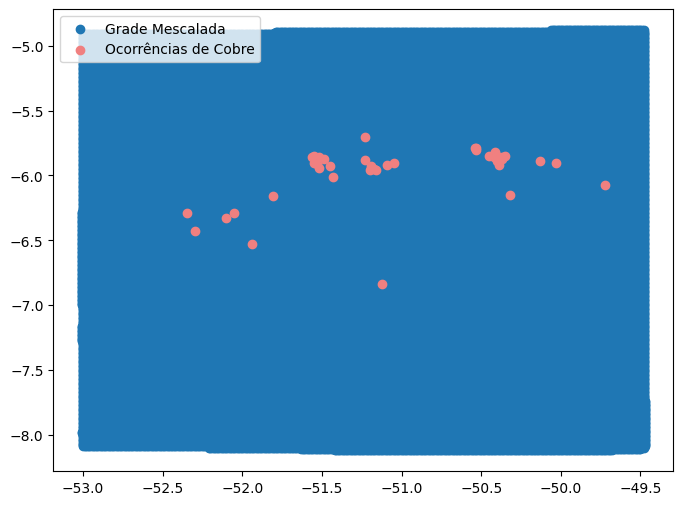

In [21]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(df_merge_data['longitude'], df_merge_data['latitude'], label='Grade Mescalada')
ax.scatter(df_minerio['longitude'], df_minerio['latitude'], color='lightcoral', label='Ocorrências de Cobre')
plt.legend()
plt.show()

In [22]:
# redução da área geográfica
min_lat, max_lat = df_minerio['latitude'].min(), df_minerio['latitude'].max()
min_lon, max_lon = df_minerio['longitude'].min(), df_minerio['longitude'].max()

padding = 0.1
lat_min_padded = min_lat - padding
lat_max_padded = max_lat + padding
lon_min_padded = min_lon - padding
lon_max_padded = max_lon + padding

df_merge_data_clipped = df_merge_data[
    (df_merge_data['latitude'] >= lat_min_padded) & (df_merge_data['latitude'] <= lat_max_padded) &
    (df_merge_data['longitude'] >= lon_min_padded) & (df_merge_data['longitude'] <= lon_max_padded)
]

# reamostragem dos dados via pandas
df_merge_data_reduced = df_merge_data_clipped.sample(frac=0.03, random_state=42)

print(df_merge_data_reduced.shape)

(1133, 9)


In [23]:
# concatena inner join com reamostragem
df_minerio_merge = pd.concat([df_merge_data_reduced, df_minerio_inner], axis=0, ignore_index=True)
df_minerio_merge = df_minerio_merge.fillna(0)
df_minerio_merge['ocorrencia'] = df_minerio_merge['ocorrencia'].astype(int)
print(df_merge_data_reduced.shape)
df_minerio_merge.head(3)

(1133, 9)


,longitude,latitude,FatorF,Kd,Ud,grav_residual190km_ght,grav_residual100km,mag_asvi,mag_gt,ocorrencia
0,-50.50,-5.95,0.097683,0.352167,-0.189589,0.001736,-6.499377,97.921883,0.016415,0
1,-51.88,-6.49,0.056461,-0.311667,-0.368172,0.000978,0.110644,75.368767,0.033381,0
2,-51.39,-6.51,0.037565,-0.021877,-0.358604,0.000427,-1.090122,40.889549,0.019091,0


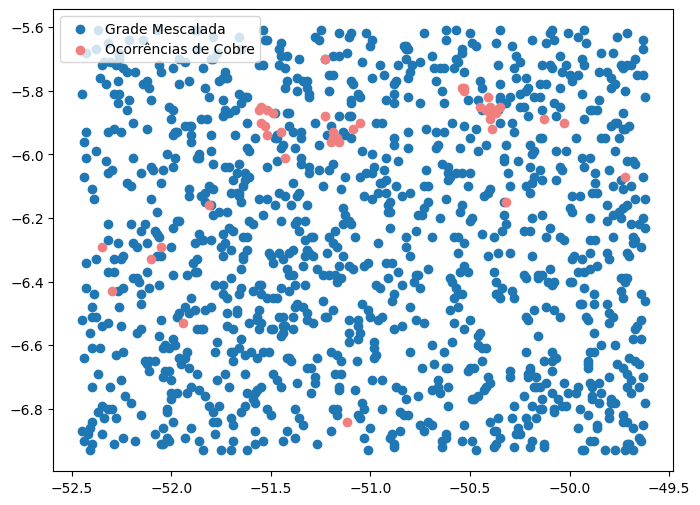

In [24]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(
    df_minerio_merge[df_minerio_merge["ocorrencia"] == 0]["longitude"],
    df_minerio_merge[df_minerio_merge["ocorrencia"] == 0]["latitude"],
    label="Grade Mescalada",
)
ax.scatter(
    df_minerio_merge[df_minerio_merge["ocorrencia"] == 1]["longitude"],
    df_minerio_merge[df_minerio_merge["ocorrencia"] == 1]["latitude"],
    color="lightcoral",
    label="Ocorrências de Cobre",
)
plt.legend()
plt.show()

In [25]:
print(f"Dados de espectrometria: {spec_data.shape[0]}")
print(f"Dados de gravimetria: {grav_data.shape[0]}")
print(f"Mesclagem de dados (espec + gravim): {df_merge_data.shape[0]}")
print(f"Redução de mesclagem de dados (espec + gravim): {df_merge_data_reduced.shape[0]}")
print(f"Mesclagem com cobre (espec + gravim + cobre): {df_minerio_merge.shape[0]}")

Dados de espectrometria: 116745
Dados de gravimetria: 114011
Mesclagem de dados (espec + gravim): 113918
Redução de mesclagem de dados (espec + gravim): 1133
Mesclagem com cobre (espec + gravim + cobre): 1175


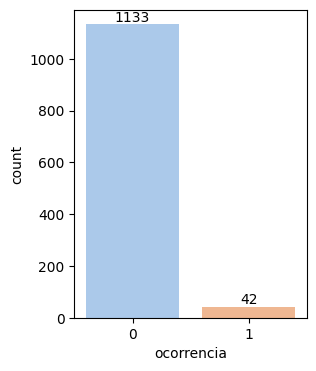

In [26]:
plt.figure(figsize=(3, 4))
ax = sns.countplot(x="ocorrencia", data=df_minerio_merge, palette="pastel")
for i in ax.containers:
    ax.bar_label(i)

In [27]:
print(
    "Cobre:",
    round(df_minerio_merge["ocorrencia"].value_counts()[1] / len(df_minerio_merge) * 100, 2),
    "% do dataset",
)

Cobre: 3.57 % do dataset


In [28]:
dict_map_idx_lon = dict(zip(df_minerio_merge.index, df_minerio_merge["longitude"]))
dict_map_idx_lat = dict(zip(df_minerio_merge.index, df_minerio_merge["latitude"]))
df_minerio_merge = df_minerio_merge.drop(["longitude", "latitude"], axis=1)

In [29]:
df_minerio_merge = df_minerio_merge[
    [
        "FatorF",
        "Kd",
        "Ud",
        "grav_residual190km_ght",
        "grav_residual100km",
        "mag_asvi",
        "mag_gt",
        "ocorrencia",
    ]
]

## aprendizado de máquina

### split treino-teste

- split padrão -> 70% treino e 30% teste

In [30]:
X = df_minerio_merge.drop(["ocorrencia"], axis=1)
y = df_minerio_merge["ocorrencia"].values
X_train, X_test, y_train, y_test = split_data(X, y)

Train shape: (822, 7), Test shape: (353, 7)
Class balance - Train: 3.53%, Test: 3.68%


### pipeline

In [31]:
models = {
    "Random Forest": RandomForestClassifier(class_weight="balanced", random_state=42, n_jobs=-1),
    "Logistic Regression": LogisticRegression(
        class_weight="balanced", max_iter=1000, random_state=42, penalty="l2", solver="lbfgs"
    ),
    "SVM": SVC(
        class_weight="balanced",
        kernel="rbf",
        C=1.0,
        gamma="scale",
        probability=True,
        random_state=42,
    ),
    "XGBoost": XGBClassifier(
        scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]),
        random_state=42,
        n_jobs=-1,
        eval_metric="logloss",
    ),
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = pipeline_ml(models, cv, X_train, X_test, y_train, y_test)



Tempo total de treino Random Forest: 0.29 min
Random Forest - CV AUC: 0.678 (±0.033)
ROC-AUC: 0.716
F1 Score: 0.000

Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       340
           1       0.00      0.00      0.00        13

    accuracy                           0.96       353
   macro avg       0.48      0.50      0.49       353
weighted avg       0.93      0.96      0.95       353


Optimal Decision Threshold: 0.150




Tempo total de treino Logistic Regression: 0.13 min
Logistic Regression - CV AUC: 0.651 (±0.101)
ROC-AUC: 0.687
F1 Score: 0.114

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.65      0.78       340
           1       0.06      0.62      0.11        13

    accuracy                           0.65       353
   macro avg       0.52      0.63      0.45       353
weighted avg       0.94      0.65      0.76       353


Optimal Deci

---

- Random Forest

    - Alto desempenho na classe majoritária (precision = 0.96, recall = 1.00), mas falha completa na classe minoritária (F1 = 0.0).

    - Apesar de um ROC-AUC razoável (0.716), o modelo é inútil para prever a classe 1 no threshold padrão (0.5). O threshold ótimo encontrado (0.15) sugere que probabilidades baixas já indicam a classe 1, mas ainda não resolve o problema.


- Regressão Logística

    - Melhor recall (0.62) para a classe 1, mas precision muito baixa (0.06), resultando em muitos falsos positivos.

    - F1-Score (0.114) ligeiramente melhor que os outros, mas ainda insatisfatório.


- SVM (Support Vector Machine)

    - Pior desempenho geral (ROC-AUC = 0.416), com recall alto (0.77) para a classe 1, mas precision extremamente baixa (0.04).

    - Threshold muito baixo (0.035), indicando que o modelo quase sempre classifica como positivo, o que não é útil.


- XGBoost

    - Melhor ROC-AUC (0.722) entre os modelos, mas ainda com F1-Score baixo (0.10) para a classe 1.

    - Threshold ótimo muito baixo (0.018), reforçando a dificuldade de prever a classe minoritária.

---

- Recomendações

  - Balanceamento dos dados: Técnicas como SMOTE, undersampling ou class weights podem melhorar a detecção da classe 1.

  - Métricas alternativas: Dado o desbalanceamento, foque em precision-recall AUC ou F1-Score em vez de ROC-AUC.

  - Ajuste os thresholds: Use o threshold ótimo encontrado (ex: 0.15 para Random Forest) para melhorar o trade-off entre precision e recall.

---

In [32]:
# fig, axs = plt.subplots(1, 4, figsize=(10, 4))
# for mdl, ax in zip(models.keys(), axs.flatten()):
#     y_proba = models[mdl].predict_proba(X_test)[:, 1]
#     fpr, tpr, threshold = roc_curve(y_test, y_proba)
#     roc_auc = auc(fpr, tpr)

#     # plot
#     ax.plot(fpr, tpr, label="AUC={}".format(round(roc_auc, 2)))
#     ax.plot([0, 1], [0, 1], "r--")
#     ax.legend()
#     ax.grid(visible=True, alpha=0.6, linestyle="--")
#     ax.set_title(mdl)
# plt.tight_layout()
# plt.show()

- Soluções:
  - Existem diferentes soluções:
    - undersampling da classe majoritária (0)
    - oversampling da classe minoritária (1)

### pipeline undersampling

In [33]:
models = {
    "Random Forest": RandomForestClassifier(class_weight="balanced", random_state=42, n_jobs=-1),
    "Logistic Regression": LogisticRegression(
        class_weight="balanced", max_iter=1000, random_state=42, penalty="l2", solver="lbfgs"
    ),
    "SVM": SVC(
        class_weight="balanced",
        kernel="rbf",
        C=1.0,
        gamma="scale",
        probability=True,
        random_state=42,
    ),
    "XGBoost": XGBClassifier(
        scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]),
        random_state=42,
        n_jobs=-1,
        eval_metric="logloss",
    ),
}

# Create pipelines with undersampling
pipelines_unders = {}
for name, model in models.items():
    if name in {"Logistic Regression", "SVM"}:
        # Adiciona StandardScaler para modelos sensíveis à escala
        pipelines_unders[name] = make_pipeline(
            RandomUnderSampler(random_state=42), StandardScaler(), model
        )
    else:
        pipelines_unders[name] = make_pipeline(RandomUnderSampler(random_state=42), model)

results_unders = pipeline_ml_undersampling(pipelines_unders, cv, X_train, X_test, y_train, y_test)


=== Training Random Forest ===
Tempo total de treino Random Forest: 0.06 min
Test ROC-AUC: 0.716
Test F1 Score: 0.134
Test Average Precision: 0.088

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.67      0.80       340
           1       0.07      0.69      0.13        13

    accuracy                           0.67       353
   macro avg       0.53      0.68      0.47       353
weighted avg       0.95      0.67      0.77       353

Optimal Decision Threshold: 0.810

=== Training Logistic Regression ===
Tempo total de treino Logistic Regression: 0.02 min
Test ROC-AUC: 0.705
Test F1 Score: 0.101
Test Average Precision: 0.088

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.60      0.74       340
           1       0.06      0.62      0.10        13

    accuracy                           0.60       353
   macro avg       0.52      0.61      0.42       353
weighted 

---

- Random Forest

    - Melhor desempenho geral (ROC-AUC: 0.716 / F1-Score: 0.134 para classe 1).

    - Recall alto para classe 1 (69%), mas precisão muito baixa (7%) – muitos falsos positivos.

    - Threshold alto (0.810): o modelo só classifica como "1" quando tem confiança elevada.

    - AUC consistente (CV: 0.667 ± 0.109), indicando robustez moderada.


- Regressão Logística

    - Desempenho moderado (ROC-AUC: 0.705 / F1-Score: 0.101).

    - Recall razoável (62%), mas precisão extremamente baixa (6%) – quase inviável na prática.

    - Threshold mais baixo (0.590), refletindo menor confiança nas previsões.

    - AUC estável (CV: 0.683 ± 0.078), porém ainda limitado.


- SVM

    - Resultados competitivos (ROC-AUC: 0.718 / F1-Score: 0.120).

    - Recall aceitável (62%), mas precisão muito baixa (7%).

    - Threshold intermediário (0.511), equilibrando parcialmente as classes.

    - Alta variabilidade no CV AUC (±0.128), sugerindo sensibilidade aos dados.


- XGBoost

    - ROC-AUC razoável (0.696), mas F1-Score baixo (0.095) devido à precisão péssima (5%).

    - Recall altíssimo (77%), mas com muitos falsos positivos (precisão inaceitável).

    - Threshold extremo (0.999): o modelo praticamente nunca prevê "1" sem confiança absoluta.

    - Alta variabilidade no CV (±0.121), possivelmente devido a resíduos de desbalanceamento.


---

- Problemas Identificados:

  - Trade-off Entre Recall e Precisão

      - Todos os modelos priorizaram recall (54–77%) para a classe 1, mas com precisão muito baixa (5–7%).

      - Consequência: Muitos falsos positivos, inviabilizando aplicações reais (ex.: custo alto de ações baseadas em previsões erradas).

  - Thresholds Otimizados, mas Insuficientes

      - Ajustar o threshold melhorou o recall, mas não resolveu a baixa precisão.

      - Caso extremo (XGBoost): Threshold = 0.999 praticamente ignora a classe 1, tornando o modelo inútil para detecção.

  - Undersampling Pode Ter Removido Informação Relevante

      - A redução da classe majoritária pode ter eliminado padrões importantes, afetando a generalização.

      - Alternativas sugeridas:

          - Testar SMOTE (oversampling) para preservar a distribuição original.

          - Usar class_weight="balanced" ou loss functions customizadas (ex.: focal loss).

  - AUC Alto ≠ Desempenho Prático

      - Exemplo: XGBoost teve o pior F1-Score (0.095) apesar de um AUC razoável (0.696).

      - Métrica mais relevante: Average Precision (AP) – todos os modelos tiveram AP < 0.21, confirmando a dificuldade com a classe 1.

---

### pipeline oversampling

In [34]:
models = {
    "Random Forest": RandomForestClassifier(class_weight="balanced", random_state=42, n_jobs=-1),
    "Logistic Regression": LogisticRegression(
        class_weight="balanced", max_iter=1000, random_state=42, penalty="l2", solver="lbfgs"
    ),
    "SVM": SVC(
        class_weight="balanced",
        kernel="rbf",
        C=1.0,
        gamma="scale",
        probability=True,
        random_state=42,
    ),
    "XGBoost": XGBClassifier(
        scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]),
        random_state=42,
        n_jobs=-1,
        eval_metric="logloss",
    ),
}

# Create pipelines with overrsampling
pipelines_overs = {}
for name, model in models.items():
    if name in {"Logistic Regression", "SVM"}:
        # Add StandardScaler for Logistic Regression
        pipelines_overs[name] = make_pipeline(StandardScaler(), model)
    else:
        pipelines_overs[name] = make_pipeline(model)

results_overs = pipeline_ml_oversampling(
    pipelines=pipelines_overs, cv=cv, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test
)


=== Training Random Forest ===
Training time Random Forest: 0.06 min
CV AUC: 0.735 (±0.121)
Test ROC-AUC: 0.677
Test F1 Score: 0.308
Test Average Precision: 0.296

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       340
           1       0.31      0.31      0.31        13

    accuracy                           0.95       353
   macro avg       0.64      0.64      0.64       353
weighted avg       0.95      0.95      0.95       353

Optimal Decision Threshold: 0.660

=== Training Logistic Regression ===
Training time Logistic Regression: 0.0 min
CV AUC: 0.652 (±0.100)
Test ROC-AUC: 0.676
Test F1 Score: 0.113
Test Average Precision: 0.072

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.64      0.78       340
           1       0.06      0.62      0.11        13

    accuracy                           0.64       353
   macro avg       0.52      0.63 

---

- Random Forest

    - Melhor F1-Score (0.308) entre os modelos, com precisão (31%) e recall (31%) equilibrados para a classe 1.

    - AUC moderado (0.677), mas consistente no CV (±0.121).

    - Threshold razoável (0.660), indicando confiança moderada nas previsões positivas.

    - Classificação da classe 0 excelente (97% precision/recall).


- Regressão Logística

    - Pior desempenho (F1 = 0.113), com precisão muito baixa (6%) e recall alto (62%).

    - Threshold baixo (0.565), refletindo baixa confiança nas previsões positivas.

    - Pouco útil na prática devido à alta taxa de falsos positivos.


- SVM

    - Melhor ROC-AUC (0.844), mas F1-Score (0.256) inferior ao Random Forest.

    - Recall alto (77%), mas precisão muito baixa (15%) – muitos falsos positivos.

    - Threshold alto (0.879): modelo exige alta confiança para prever a classe 1.

    - Bom desempenho na classe 0 (99% precision).


- XGBoost

    - AUC competitivo (0.747), mas F1-Score (0.245) limitado pela baixa precisão (17%).

    - Recall razoável (46%), mas threshold extremo (0.961): quase nunca classifica como "1".

    - Desempenho sólido na classe 0 (98% precision).


---

- Problemas persistentes:

    - Precisão Baixa para Classe 1

        - Mesmo com SMOTE, a precisão da classe 1 permanece ≤31% (Random Forest foi o melhor).

        - SVM e XGBoost sofrem com falsos positivos (precision ≤17%).

    - Trade-off entre Métricas

        - SVM tem o melhor AUC (0.844), mas F1-Score inferior ao Random Forest.

        - XGBoost tem alta variabilidade no CV (±0.115), indicando instabilidade.

    - Thresholds Altos para Classe 1

        - XGBoost (0.961) e SVM (0.879) exigem quase certeza para prever a classe 1, limitando sua utilidade.

---

### pipeline combinação oversampling + undersampling

Ref: https://www.kaggle.com/code/marcinrutecki/best-techniques-and-metrics-for-imbalanced-dataset

In [35]:
models = {
    "Random Forest": RandomForestClassifier(class_weight="balanced", random_state=42, n_jobs=-1),
    "Logistic Regression": LogisticRegression(
        class_weight="balanced", max_iter=1000, random_state=42, penalty="l2", solver="lbfgs"
    ),
    "SVM": SVC(
        class_weight="balanced",
        kernel="rbf",
        C=1.0,
        gamma="scale",
        probability=True,
        random_state=42,
    ),
    "XGBoost": XGBClassifier(
        scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]),
        random_state=42,
        n_jobs=-1,
        eval_metric="logloss",
    ),
}

pipelines_comb = {}
for name, model in models.items():
    if name in {"Logistic Regression", "SVM"}:
        # Add StandardScaler for Logistic Regression
        pipelines_comb[name] = make_pipeline(StandardScaler(), model)
    else:
        pipelines_comb[name] = make_pipeline(model)

results_smote_tomek = pipeline_ml_smote_tomek(
    pipelines=pipelines_comb, cv=cv, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test
)


=== Training Random Forest ===
Total training time for Random Forest: 0.04 min
Test ROC-AUC: 0.682
Test F1 Score: 0.333
Test Average Precision: 0.201

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       340
           1       0.36      0.31      0.33        13

    accuracy                           0.95       353
   macro avg       0.67      0.64      0.65       353
weighted avg       0.95      0.95      0.95       353

Optimal Decision Threshold: 0.560

=== Training Logistic Regression ===
Total training time for Logistic Regression: 0.01 min
Test ROC-AUC: 0.614
Test F1 Score: 0.104
Test Average Precision: 0.054

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.66      0.79       340
           1       0.06      0.54      0.10        13

    accuracy                           0.66       353
   macro avg       0.52      0.60      0.45       353
weigh

---

- Random Forest

    - Melhor F1-Score (0.320) entre os modelos, com precisão (33%) e recall (31%) equilibrados para a classe 1.

    - AUC baixo (0.649), mas consistente no CV (±0.068).

    - Threshold razoável (0.610), indicando confiança moderada nas previsões positivas.

    - Excelente desempenho na classe 0 (97-98% precision/recall).


- Regressão Logística

    - Pior desempenho (F1 = 0.126), com precisão muito baixa (7%) e recall alto (69%).

    - Threshold padrão (0.5), refletindo baixa confiança nas previsões positivas.

    - Pouco útil na prática devido à alta taxa de falsos positivos.


- SVM

    - Melhor ROC-AUC (0.819), mas F1-Score (0.215) inferior ao Random Forest.

    - Recall aceitável (54%), mas precisão muito baixa (13%) – muitos falsos positivos.

    - Threshold alto (0.830): modelo exige alta confiança para prever a classe 1.

    - Bom desempenho na classe 0 (98% precision).


- XGBoost

    - AUC competitivo (0.769), mas F1-Score (0.263) limitado pela baixa precisão (20%).

    - Recall moderado (38%), mas threshold extremo (0.972): raramente classifica como "1".

    - Desempenho sólido na classe 0 (98% precision).

---

### melhor modelo

- fazendo uso apenas do modelo Random Forest + SMOTE + Tomek Links

In [50]:
best_model = RandomForestClassifier(class_weight="balanced", random_state=42, n_jobs=-1)

min_minority_samples = min([
    np.sum(y_train[test_idx] == 1) for _, test_idx in cv.split(X_train, y_train)
])

k_neighbors = min(5, min_minority_samples - 1) if min_minority_samples > 1 else 1

pipeline = ImbPipeline([
    ("smote", SMOTE(random_state=42, sampling_strategy="auto", k_neighbors=k_neighbors)),
    ("classifier", model),
])

pipeline.fit(X_train, y_train)

print('Pipeline Sem Threshold Ótimo')
evaluate_model(pipeline, X_test, y_test)

print('\nPipeline Com Threshold Ótimo')
# Apply threshold
# Optimal Decision Threshold: 0.961
evaluate_model_custom(pipeline, X_test, y_test, 0.961)

Pipeline Sem Threshold Ótimo
ROC-AUC: 0.747
F1 Score: 0.245

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.91      0.94       340
           1       0.17      0.46      0.24        13

    accuracy                           0.90       353
   macro avg       0.57      0.69      0.59       353
weighted avg       0.95      0.90      0.92       353


Optimal Decision Threshold: 0.961



Pipeline Com Threshold Ótimo
ROC-AUC: 0.747
F1 Score: 0.276

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       340
           1       0.25      0.31      0.28        13

    accuracy                           0.94       353
   macro avg       0.61      0.64      0.62       353
weighted avg       0.95      0.94      0.94       353


Optimal Decision Threshold: 0.961




In [51]:
y_pred = model.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]
# Apply threshold
# Optimal Decision Threshold: 0.961
y_pred_custom = (y_proba >= 0.961).astype(int)

In [52]:
print(f"Class 1: {sum(y_pred == 0)}")
print(f"Class 1 (Custom): {sum(y_pred_custom == 1)}")

Class 1: 317
Class 1 (Custom): 16


- feature importance do modelo

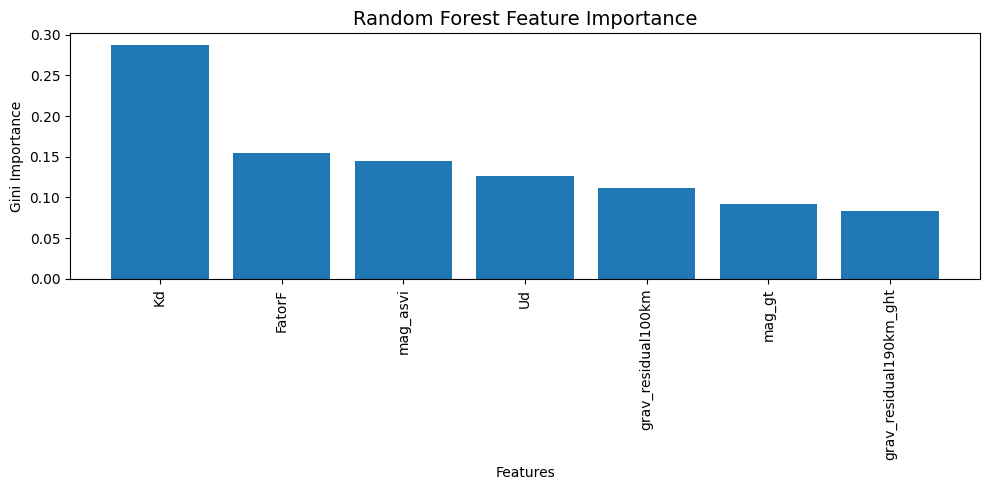

In [53]:
rf_model = pipeline.named_steps['classifier']

importances = rf_model.feature_importances_
feature_names = X_train.columns

indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 5))
plt.title("Random Forest Feature Importance", fontsize=14)
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), feature_names[indices], rotation=90)
plt.xlabel("Features")
plt.ylabel("Gini Importance")
plt.tight_layout()
plt.show()

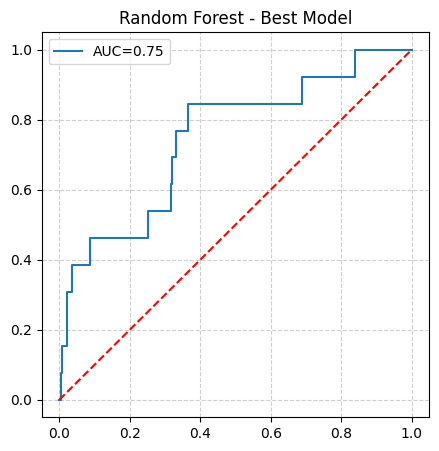

In [54]:
fpr, tpr, threshold = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# plot all this
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(fpr, tpr, label="AUC={}".format(round(roc_auc, 2)))
ax.plot([0, 1], [0, 1], "r--")
ax.legend()
ax.set_title("Random Forest - Best Model")
ax.grid(visible=True, alpha=0.6, linestyle="--")
plt.show()

### SHAP

Ref: https://shap.readthedocs.io/en/latest/

In [55]:
feature_names = X_train.columns.tolist()

explainer = shap.Explainer(rf_model)
shap_values = explainer(X_train)
shap_values_pos = shap_values[1]

In [56]:
print(f"Data shape: {X_train.shape}")
print(f"All SHAP values shape: {np.array(shap_values).shape}")
print(f"SHAP values for class 1: {shap_values.shape}")

Data shape: (822, 7)
All SHAP values shape: (822, 7)
SHAP values for class 1: (822, 7)


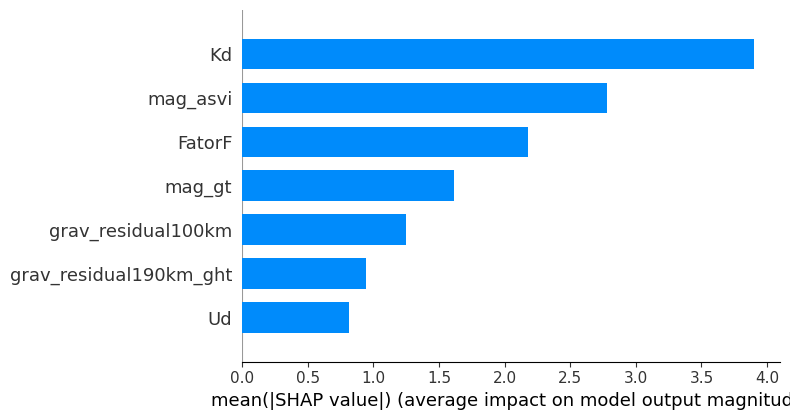

In [57]:
shap.summary_plot(
    shap_values,
    pd.DataFrame(X_train, columns=X_train.columns),
    feature_names=X_train.columns.tolist(),
    plot_type="bar",
)

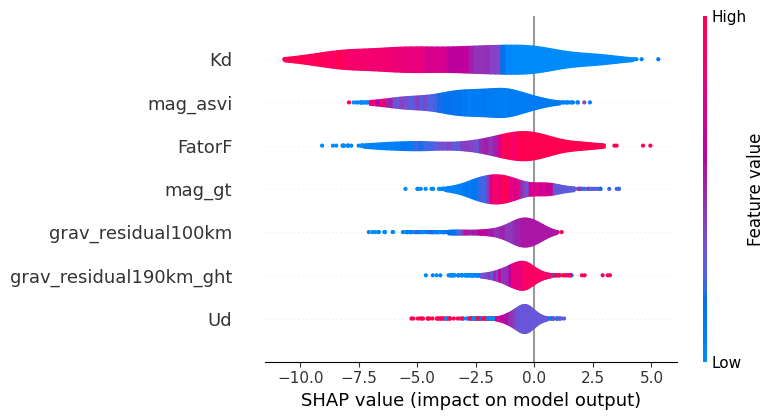

In [58]:
shap.summary_plot(
    shap_values, pd.DataFrame(X_train, columns=X_train.columns), plot_type="violin"
)

### Mapa

In [59]:
coord_df = pd.DataFrame.from_dict(dict_map_idx_lon, orient="index")
coord_df["latitude"] = dict_map_idx_lat
coord_df.columns = ["longitude", "latitude"]
coord_df.head(3)

,longitude,latitude
0,-50.50,-5.95
1,-51.88,-6.49
2,-51.39,-6.51


In [60]:
results = X_test.copy()
results["probability"] = y_proba
results["prediction"] = y_pred_custom
results.head(3)

,FatorF,Kd,Ud,grav_residual190km_ght,grav_residual100km,mag_asvi,mag_gt,probability,prediction
425,0.088365,0.498377,0.495197,0.000726,3.253272,906.429382,0.452149,0.000156,0
927,0.083549,-0.983150,-0.695050,0.000086,-13.548951,63.895351,0.023870,0.000076,0
942,0.015140,-3.563424,-0.695464,0.000716,-1.844845,50.014801,0.011086,0.003286,0


In [61]:
results = pd.merge(results, coord_df, left_index=True, right_index=True, how="inner")
results.head(3)

,FatorF,Kd,Ud,grav_residual190km_ght,grav_residual100km,mag_asvi,mag_gt,probability,prediction,longitude,latitude
425,0.088365,0.498377,0.495197,0.000726,3.253272,906.429382,0.452149,0.000156,0,-49.81,-6.31
927,0.083549,-0.983150,-0.695050,0.000086,-13.548951,63.895351,0.023870,0.000076,0,-51.66,-6.13
942,0.015140,-3.563424,-0.695464,0.000716,-1.844845,50.014801,0.011086,0.003286,0,-49.84,-5.68


In [62]:
results.to_csv(Path(dir_projeto, "Entrada", "resultados_cobre.csv"), sep=";", index=False)

In [63]:
mineral_locations = results[results["prediction"] == 1]
print(f"Locais com alta confiança de cobre: {len(mineral_locations)}")

Locais com alta confiança de cobre: 16


In [64]:
# https://python-visualization.github.io/folium/latest/user_guide/raster_layers/tiles.html
fig = Figure(width=700, height=600)

m = folium.Map(
    location=[mineral_locations["latitude"].mean(), mineral_locations["longitude"].mean()],
    zoom_start=7,
)

for _, row in df_minas.iterrows():
    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]], radius=5, color="red", fill=True, tooltip="Mina"
    ).add_to(m)


for _, row in df_minerio.iterrows():
    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]], radius=5, color="sienna", fill=True, tooltip="Cobre"
    ).add_to(m)


for _, row in mineral_locations.iterrows():
    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=5,
        color="lightcoral",
        fill=True,
        tooltip=f"Cobre Prob: {row['probability']:.3f}",
    ).add_to(m)


fig.add_child(m)